<a href="https://colab.research.google.com/github/nanopiero/fusion_2d_od/blob/main/notebooks/test_clustering_hidden_parameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# 1. Generate Matrices M[k,n] (5x3) of size (10x10)
k = 5
n = 3
dim = 10
M = torch.randn(k, n, dim, dim)  # Random matrices

In [21]:
# 2. Generate dataset
N = 50000  # Total samples
batch_size = 1000
num_batches = N // batch_size

torch.manual_seed(42)
x_data = torch.randn(N, dim)
L_data = torch.arange(num_batches).repeat_interleave(batch_size) % k  # L values shared within 1000s

y_data = []
for i in range(N):
    L_i = L_data[i]
    x_i = x_data[i]
    y_i = torch.max(M[L_i,2] @ torch.relu(M[L_i,1] @ torch.relu(M[L_i,0] @ x_i)))
    y_data.append(y_i)

y_data = torch.tensor(y_data).unsqueeze(1)

In [22]:
# 3. Define Model
class DeepMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_batches):
        super(DeepMLP, self).__init__()
        self.theta = nn.Parameter(torch.randn(num_batches, 2))  # Latent variable
        self.fc1 = nn.Linear(input_dim + 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        # self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        # self.fc6 = nn.Linear(hidden_dim, hidden_dim)
        # self.fc7 = nn.Linear(hidden_dim, hidden_dim)
        # self.fc8 = nn.Linear(hidden_dim, hidden_dim)
        self.fc7 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, indices):
        theta_batch = self.theta[indices // 1000, :]
        noise = torch.normal(mean=torch.zeros_like(theta_batch),
                             std=torch.ones_like(theta_batch))
        x = torch.cat([x, theta_batch + noise], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        # x = torch.relu(self.fc4(x))
        # x = torch.relu(self.fc5(x))
        # x = torch.relu(self.fc6(x))
        # x = torch.relu(self.fc7(x))
        # x = torch.relu(self.fc8(x))
        x = self.fc7(x)
        return x, theta_batch

# Model and optimizer
model = DeepMLP(input_dim=dim, hidden_dim=256, output_dim=1, num_batches=num_batches)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model = model.cuda()

In [23]:
# Training
num_epochs = 2000
for epoch in range(num_epochs):
    perm = torch.randperm(N)
    x_shuffled, y_shuffled, L_shuffled = x_data[perm], y_data[perm], L_data[perm]

    epoch_loss = 0
    for i in range(0, N, batch_size):
        indices = perm[i:i+batch_size]
        x_batch = x_shuffled[i:i+batch_size].cuda()
        y_batch = y_shuffled[i:i+batch_size].cuda()

        optimizer.zero_grad()
        y_pred, theta_batch = model(x_batch, indices)
        loss = criterion(y_pred, y_batch) + (torch.relu(theta_batch - 10) + torch.relu(-10 - theta_batch)).mean()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")



Epoch 1/2000, Loss: 15850.3383
Epoch 2/2000, Loss: 10734.0698
Epoch 3/2000, Loss: 10324.7455
Epoch 4/2000, Loss: 10121.5178
Epoch 5/2000, Loss: 10001.0486
Epoch 6/2000, Loss: 9918.3993
Epoch 7/2000, Loss: 9791.4544
Epoch 8/2000, Loss: 9652.6521
Epoch 9/2000, Loss: 9485.5620
Epoch 10/2000, Loss: 9304.6177
Epoch 11/2000, Loss: 9131.2638
Epoch 12/2000, Loss: 8836.9611
Epoch 13/2000, Loss: 8578.7968
Epoch 14/2000, Loss: 8371.5449
Epoch 15/2000, Loss: 8075.5549
Epoch 16/2000, Loss: 7741.0514
Epoch 17/2000, Loss: 7489.4976
Epoch 18/2000, Loss: 7214.5316
Epoch 19/2000, Loss: 6857.0437
Epoch 20/2000, Loss: 6677.1865
Epoch 21/2000, Loss: 6397.7716
Epoch 22/2000, Loss: 6084.7130
Epoch 23/2000, Loss: 5809.5753
Epoch 24/2000, Loss: 5645.7694
Epoch 25/2000, Loss: 5542.7056
Epoch 26/2000, Loss: 5217.5261
Epoch 27/2000, Loss: 5028.6521
Epoch 28/2000, Loss: 4765.7569
Epoch 29/2000, Loss: 4696.3054
Epoch 30/2000, Loss: 4465.0673
Epoch 31/2000, Loss: 4349.2388
Epoch 32/2000, Loss: 4219.6685
Epoch 33/200

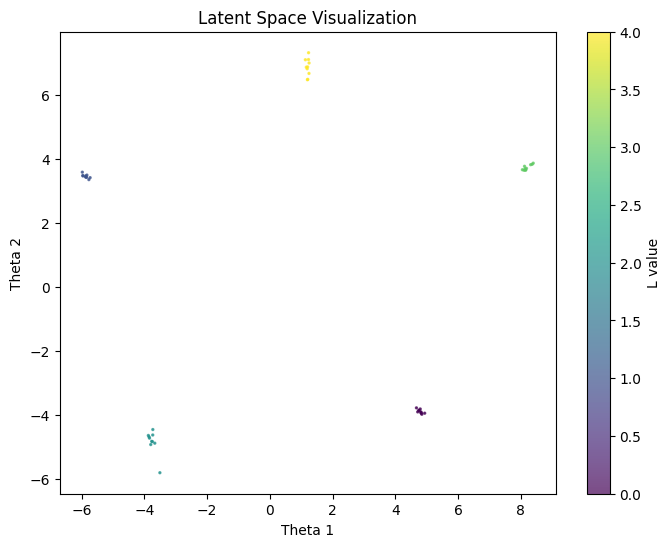

In [17]:
# Avec 5 couches:
# Extract learned theta
theta_learned = model.theta.detach().cpu().numpy()
L_colors = np.array([i % k for i in range(num_batches)])

# Plot latent space
plt.figure(figsize=(8,6))
plt.scatter(theta_learned[:,0], theta_learned[:,1], c=L_colors, cmap='viridis',
            alpha=0.7, s=2)
plt.colorbar(label='L value')
plt.xlabel('Theta 1')
plt.ylabel('Theta 2')
plt.title('Latent Space Visualization')
plt.show()

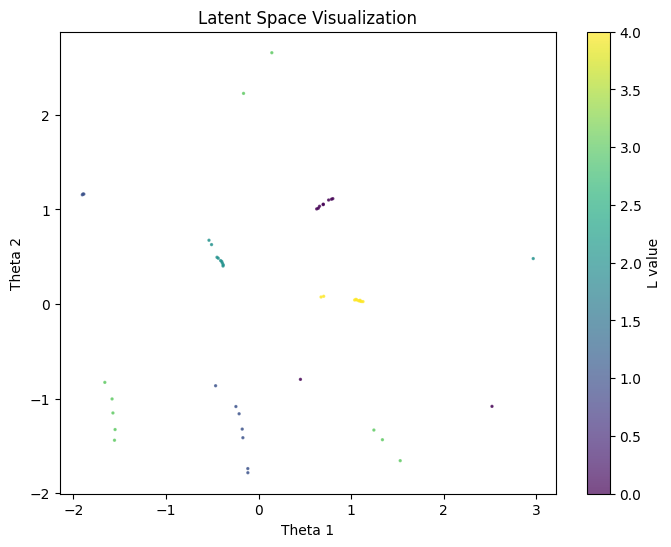

In [24]:
# Avec 10 couches et sans bruit sur le theta ni force de rappel
# Extract learned theta
theta_learned = model.theta.detach().cpu().numpy()
L_colors = np.array([i % k for i in range(num_batches)])

# Plot latent space
plt.figure(figsize=(8,6))
plt.scatter(theta_learned[:,0], theta_learned[:,1], c=L_colors, cmap='viridis',
            alpha=0.7, s=2)
plt.colorbar(label='L value')
plt.xlabel('Theta 1')
plt.ylabel('Theta 2')
plt.title('Latent Space Visualization')
plt.show()